#Imports & Path

In [1]:
import os, sys
sys.path.append(os.path.abspath(".."))

import pandas as pd

from src.data_loader import MarketDataConfig, fetch_prices, compute_returns
from src.portfolio import Portfolio, portfolio_returns
from src.var_models import historical_var, parametric_var_normal
from src.backtest import var_exceptions, exception_summary
from src.plots import plot_var_overlay
from src.scaling import scale_to_dollars


#Config & Data

In [2]:
cfg = MarketDataConfig(
    tickers=["SPY", "TLT", "GLD", "UUP"],
    start="2015-01-01",
    use_log_returns=True
)

prices = fetch_prices(cfg)
rets = compute_returns(prices, use_log=cfg.use_log_returns)

prices.tail(), rets.tail()


(Ticker             GLD         SPY        TLT    UUP
 Date                                                
 2026-02-11  467.630005  691.960022  88.059998  26.83
 2026-02-12  451.390015  681.270020  89.230003  26.82
 2026-02-13  462.619995  681.750000  89.720001  26.82
 2026-02-17  448.200012  682.849976  89.870003  26.91
 2026-02-18  458.279999  686.289978  89.529999  27.08,
 Ticker           GLD       SPY       TLT       UUP
 Date                                              
 2026-02-11  0.011247 -0.000231 -0.005323  0.001119
 2026-02-12 -0.035346 -0.015569  0.013199 -0.000373
 2026-02-13  0.024574  0.000704  0.005476  0.000000
 2026-02-17 -0.031666  0.001612  0.001670  0.003350
 2026-02-18  0.022241  0.005025 -0.003790  0.006297)

#Portfolio

In [3]:
port = Portfolio(weights={"SPY": 0.4, "TLT": 0.3, "GLD": 0.2, "UUP": 0.1})
pret = portfolio_returns(rets, port)

pret.describe()

NOTIONAL = 10_000_000  # $10mm demo notional 

pnl = scale_to_dollars(pret, NOTIONAL)


#VaR Models

In [4]:
WINDOW = 250

var95_hist = historical_var(pret, window=WINDOW, alpha=0.05)
var95_hist_dollars = scale_to_dollars(var95_hist, NOTIONAL)

var99_hist = historical_var(pret, window=WINDOW, alpha=0.01)
var99_hist_dollars = scale_to_dollars(var99_hist, NOTIONAL)

var95_param = parametric_var_normal(pret, window=WINDOW, alpha=0.05, use_mean=True)
var95_param_dollars = scale_to_dollars(var95_param, NOTIONAL)

var99_param = parametric_var_normal(pret, window=WINDOW, alpha=0.01, use_mean=True)
var99_param_dollars = scale_to_dollars(var99_param, NOTIONAL)

pd.concat([pret, var95_hist, var95_param], axis=1).dropna().head()


,portfolio_return,portfolio_return,portfolio_return
Date,,,
2015-12-30,-0.004677,-0.007535,-0.007564
2015-12-31,-0.002088,-0.007535,-0.007578
2016-01-04,-0.000519,-0.007535,-0.007584
2016-01-05,0.000608,-0.007535,-0.007586
2016-01-06,0.001534,-0.007535,-0.007587


#Backtest Summaries

In [5]:
b95 = var_exceptions(pnl, var95_hist_dollars)
b99 = var_exceptions(pnl, var99_hist_dollars)

sum95 = exception_summary(b95, alpha=0.05)
sum99 = exception_summary(b99, alpha=0.01)

pd.DataFrame([sum95, sum99], index=["VaR95", "VaR99"])


,n_obs,alpha,breaches,expected_breaches,breach_rate
VaR95,2548,0.05,128,127.40,0.050235
VaR99,2548,0.01,33,25.48,0.012951


#Plots

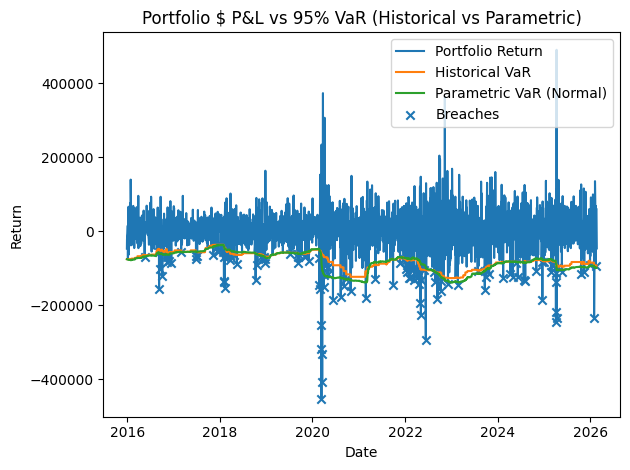

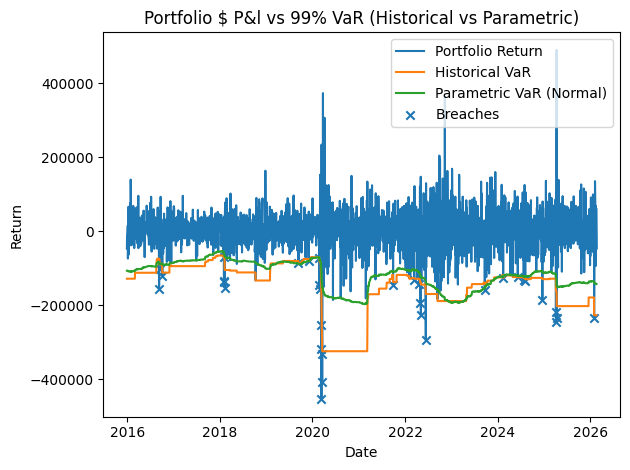

In [7]:
plot_var_overlay(
    returns=pnl,
    var_hist=var95_hist_dollars,
    var_param=var95_param_dollars,
    title="Portfolio $ P&L vs 95% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_95_overlay_dollars.png",
)
plot_var_overlay(
    returns=pnl,
    var_hist=var99_hist_dollars,
    var_param=var99_param_dollars,
    title="Portfolio $ P&l vs 99% VaR (Historical vs Parametric)",
    outpath="../outputs/figures/var_99_overlay_dollars.png",
)


#Pre-Trade Impact (Simple)

In [8]:
port_new = Portfolio(weights={"SPY": 0.6, "TLT": 0.2, "GLD": 0.1, "UUP": 0.1})

pret_new = portfolio_returns(rets, port_new)
pnl_new = scale_to_dollars(pret_new, NOTIONAL)

var95_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.05)
var95_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.05, use_mean=True)
var99_hist_new = historical_var(pret_new, window=WINDOW, alpha=0.01)
var99_param_new = parametric_var_normal(pret_new, window=WINDOW, alpha=0.01, use_mean=True)

var95_hist_new_dollars = scale_to_dollars(var95_hist_new, NOTIONAL)
var95_param_new_dollars = scale_to_dollars(var95_param_new, NOTIONAL)
var99_hist_new_dollars = scale_to_dollars(var99_hist_new, NOTIONAL)
var99_param_new_dollars = scale_to_dollars(var99_param_new, NOTIONAL)

comparison = pd.DataFrame({
    "VaR95_hist_old_$": var95_hist_dollars.dropna().round(2),
    "VaR95_hist_new_$": var95_hist_new_dollars.dropna().round(2),
    "VaR95_param_old_$": var95_param_dollars.dropna().round(2),
    "VaR95_param_new_$": var95_param_new_dollars.dropna().round(2),
    "VaR99_hist_old_$": var99_hist_dollars.dropna().round(2),
    "VaR99_hist_new_$": var99_hist_new_dollars.dropna().round(2),
    "VaR99_param_old_$": var99_param_dollars.dropna().round(2),
    "VaR99_param_new_$": var99_param_new_dollars.dropna().round(2),
}).dropna()

comparison.tail().round(2)


,VaR95_hist_old_$,VaR95_hist_new_$,VaR95_param_old_$,VaR95_param_new_$,VaR99_hist_old_$,VaR99_hist_new_$,VaR99_param_old_$,VaR99_param_new_$
Date,,,,,,,,
2026-02-11,-92104.64,-110440.05,-97856.05,-122193.87,-227230.21,-239967.13,-141401.26,-175302.64
2026-02-12,-93168.78,-111618.51,-98688.78,-123133.62,-227230.21,-239967.13,-142253.11,-176299.71
2026-02-13,-93168.78,-111618.51,-98515.03,-122988.25,-227230.21,-239967.13,-142148.96,-176172.33
2026-02-17,-93168.78,-111618.51,-98909.57,-123114.86,-227230.21,-239967.13,-142608.17,-176305.53
2026-02-18,-93168.78,-111618.51,-98872.67,-123064.84,-227230.21,-239967.13,-142629.27,-176289.34


#Summary of Pre-Trade Change

In [ ]:
latest = comparison.iloc[-1]
delta_hist_95 = latest["VaR95_hist_new_$"] - latest["VaR95_hist_old_$"]
delta_param_95 = latest["VaR95_param_new_$"] - latest["VaR95_param_old_$"]
delta_hist_99 = latest["VaR99_hist_new_$"] - latest["VaR99_hist_old_$"]
delta_param_99 = latest["VaR99_param_new_$"] - latest["VaR99_param_old_$"]

print(f"VaR95_hist_old_$: {latest['VaR95_hist_old_$']:.2f}")
print(f"VaR95_hist_new_$: {latest['VaR95_hist_new_$']:.2f}")
print(f"VaR95_param_old_$: {latest['VaR95_param_old_$']:.2f}")
print(f"VaR95_param_new_$: {latest['VaR95_param_new_$']:.2f}")
print(f"delta_hist_$: {delta_hist_95:.2f}")
print(f"delta_param_$: {delta_param_95:.2f}\n")
print(f"VaR99_hist_old_$: {latest['VaR99_hist_old_$']:.2f}")
print(f"VaR99_hist_new_$: {latest['VaR99_hist_new_$']:.2f}")
print(f"VaR99_param_old_$: {latest['VaR99_param_old_$']:.2f}")
print(f"VaR99_param_new_$: {latest['VaR99_param_new_$']:.2f}")
print(f"delta_hist_$: {delta_hist_99:.2f}")
print(f"delta_param_$: {delta_param_99:.2f}")


VaR95_hist_old_$: -93168.78
VaR95_hist_new_$: -111618.51
VaR95_param_old_$: -98872.67
VaR95_param_new_$: -123064.84
delta_hist_$: -18449.73
delta_param_$: -24192.17


VaR99_hist_old_$: -227230.21
VaR99_hist_new_$: -239967.13
VaR99_param_old_$: -142629.27
VaR99_param_new_$: -176289.34
delta_hist_$: -12736.92
delta_param_$: -33660.07
